
### 05. Acquisition operators (advanced) - Split measurements and subsampling
 In this tutorial we extend work to : 
 * by introducing split measurements that can handle a Hadamard measurement matrix,
* by discussing the choice of the subsampling pattern for accelerated acquisitions.


In [13]:
import numpy as np
import os
from spyrit.misc.disp import imagesc
import matplotlib.pyplot as plt

##### Load a batch of images



Shape of input images: torch.Size([7, 1, 64, 64])


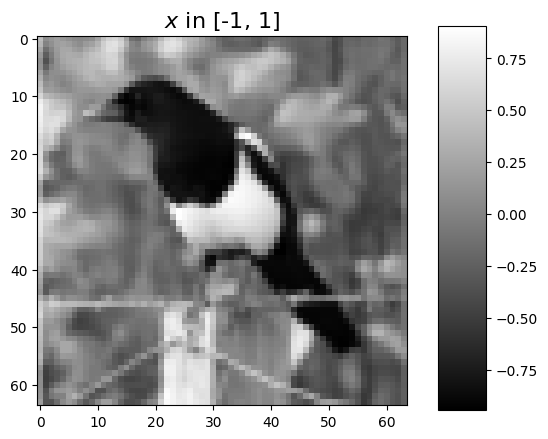

In [14]:
from spyrit.misc.statistics import transform_gray_norm
import torchvision
import torch

h = 64  # image size hxh
i = 1  # Image index (modify to change the image)
spyritPath = os.getcwd()
imgs_path = os.path.join(spyritPath, "../images")


# Create a transform for natural images to normalized grayscale image tensors
transform = transform_gray_norm(img_size=h)

# Create dataset and loader (expects class folder 'images/test/')
dataset = torchvision.datasets.ImageFolder(root=imgs_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=7)

x, _ = next(iter(dataloader))
print(f"Shape of input images: {x.shape}")

# Select image
x = x[i + 1 : i + 2, :, :, :]
x = x.detach().clone()
b, c, h, w = x.shape

# plot
x_plot = x.view(-1, h, h).cpu().numpy()
imagesc(x_plot[0, :, :], r"$x$ in [-1, 1]")

#### Split measurement operator and no noise

\begin{align}y = P\tilde{x}= \begin{bmatrix} H_{+} \\ H_{-} \end{bmatrix} \tilde{x}.\end{align}

Hadamard split measurement operator is defined in the :class:`spyrit.core.meas.HadamSplit` class.
It computes linear measurements from incoming images, where $P$ is a
linear operator (matrix) with positive entries and $\tilde{x}$ is a vectorized image.




In [15]:
import girder_client

# api Rest url of the warehouse
url = "https://pilot-warehouse.creatis.insa-lyon.fr/api/v1"

# Generate the warehouse client
gc = girder_client.GirderClient(apiUrl=url)

# Download the covariance matrix and mean image
data_folder = "./stat/"
dataId_list = [
    "63935b624d15dd536f0484a5",  # for reconstruction (imageNet, 64)
    "63935a224d15dd536f048496",  # for reconstruction (imageNet, 64)
]
cov_name = "./stat/Cov_64x64.npy"

try:
    for dataId in dataId_list:
        myfile = gc.getFile(dataId)
        gc.downloadFile(dataId, data_folder + myfile["name"])

    print(f"Created {data_folder}")

    # Load covariance matrix for "variance subsampling"
    Cov = np.load(cov_name)
    print(f"Cov matrix {cov_name} loaded")
except:
    # Set to the identity if not found for "naive subsampling"
    Cov = np.eye(h * h)
    print(f"Cov matrix {cov_name} not found! Set to the identity")

Created ./stat/
Cov matrix ./stat/Cov_64x64.npy loaded


#### Subsampling
We simulate an accelerated acquisition by subsampling the measurement matrix.
We consider two subsampling strategies:
  * "Naive subsampling" by retaining only the first $M$ rows of the measurement matrix.
  * "Variance subsampling" by retaining only the first $M$ rows of a permuted measurement matrix
    where the first rows corresponds to the coefficients with largest variance and the last ones to
    the coefficients that are close to constant.




In [16]:
from spyrit.misc.statistics import Cov2Var
from spyrit.misc.disp import add_colorbar, noaxis

# number of measurements (here, 1/4 of the pixels)
M = 64 * 64 // 4

# Compute the order matrix
# "Naive subsampling"
Cov_eye = np.eye(h * h)
Ord_nai = Cov2Var(Cov_eye)

# "Variance subsampling"
Ord_var = Cov2Var(Cov)

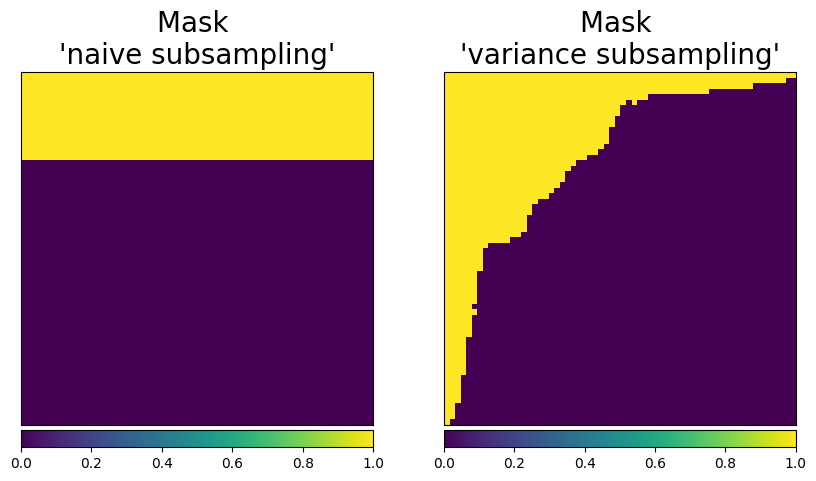

In [17]:
# sphinx_gallery_thumbnail_number = 2

# Mask for "naive subsampling"
mask_nai = np.zeros((h, h))
mask_nai[0 : int(M / h), :] = 1

# Mas for "variance subsampling"
idx = np.argsort(Ord_var.ravel(), axis=None)[::-1]
mask_var = np.zeros_like(Ord_var)
mask_var.flat[idx[0:M]] = 1

# Plot the masks
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im1 = ax1.imshow(mask_nai, vmin=0, vmax=1)
ax1.set_title("Mask \n'naive subsampling'", fontsize=20)
noaxis(ax1)
add_colorbar(im1, "bottom", size="20%")

im2 = ax2.imshow(mask_var, vmin=0, vmax=1)
ax2.set_title("Mask \n'variance subsampling'", fontsize=20)
noaxis(ax2)
add_colorbar(im2, "bottom", size="20%")

We compute the measurement and noise operators and then
simulate the measurement vector $y$.
We consider Poisson noise, i.e., a noisy measurement vector given by

\begin{align}y \sim \mathcal{P}(\alpha P \tilde{x}),\end{align}

where $\alpha$ is a scalar value that represents the maximum image intensity
(in photons).





In [18]:
from spyrit.core.noise import Poisson
from spyrit.core.meas import HadamSplit
from spyrit.core.noise import Poisson

alpha = 100.0  # number of photons

# "Naive subsampling"
# Measurement and noise operators
meas_nai_op = HadamSplit(M, h, Ord_nai)
noise_nai_op = Poisson(meas_nai_op, alpha)

# Measurement operator
x = x.view(b * c, h * w)  # vectorized image
y_nai = noise_nai_op(x)  # a noisy measurement vector

# "Variance subsampling"
meas_var_op = HadamSplit(M, h, Ord_var)
noise_var_op = Poisson(meas_var_op, alpha)
y_var = noise_var_op(x)  # a noisy measurement vector

x = x.view(b * c, h * w)  # vectorized image
print(f"Shape of vectorized image: {x.shape}")
print(f"Shape of simulated measurements y: {y_var.shape}")

Pseudo inverse will not be instanciated
Pseudo inverse will not be instanciated
Shape of vectorized image: torch.Size([1, 4096])
Shape of simulated measurements y: torch.Size([1, 2048])


#### The preprocessing operator measurements for split measurements

* in order to
compensate for the scaling factors that appear in the measurement or noise operators and poisson for affine transformation from [0,1] to [-1,1]:

\begin{align}m = \texttt{Prep}(y),\end{align}
* We compute the preprocessing operator and the measurements vectors for
the two sampling strategies.




In [19]:
from spyrit.core.prep import SplitPoisson

# "Naive subsampling"
# Preprocessing operator
prep_nai_op = SplitPoisson(alpha, meas_nai_op)
# Preprocessed measurements
m_nai = prep_nai_op(y_nai)

# "Variance subsampling"
prep_var_op = SplitPoisson(alpha, meas_var_op)
m_var = prep_var_op(y_var)
print(m_nai, m_var)

tensor([[-411.3000,  278.5600,   -9.2600,  ...,    3.9600,   -2.0400,
           -5.9600]]) tensor([[-405.6399,  -50.3000,  301.5400,  ...,    4.1400,   -2.7600,
           -9.4400]])


#### Noiseless measurements
We consider now noiseless measurements for the "naive subsampling" strategy.
We compute the required operators and the noiseless measurement vector.




In [20]:
from spyrit.core.noise import NoNoise

nonoise_nai_op = NoNoise(meas_nai_op)
y_nai_nonoise = nonoise_nai_op(x)  # a noisy measurement vector

prep_nonoise_op = SplitPoisson(1.0, meas_nai_op)
m_nai_nonoise = prep_nonoise_op(y_nai_nonoise)

We can now plot the three measurement vectors



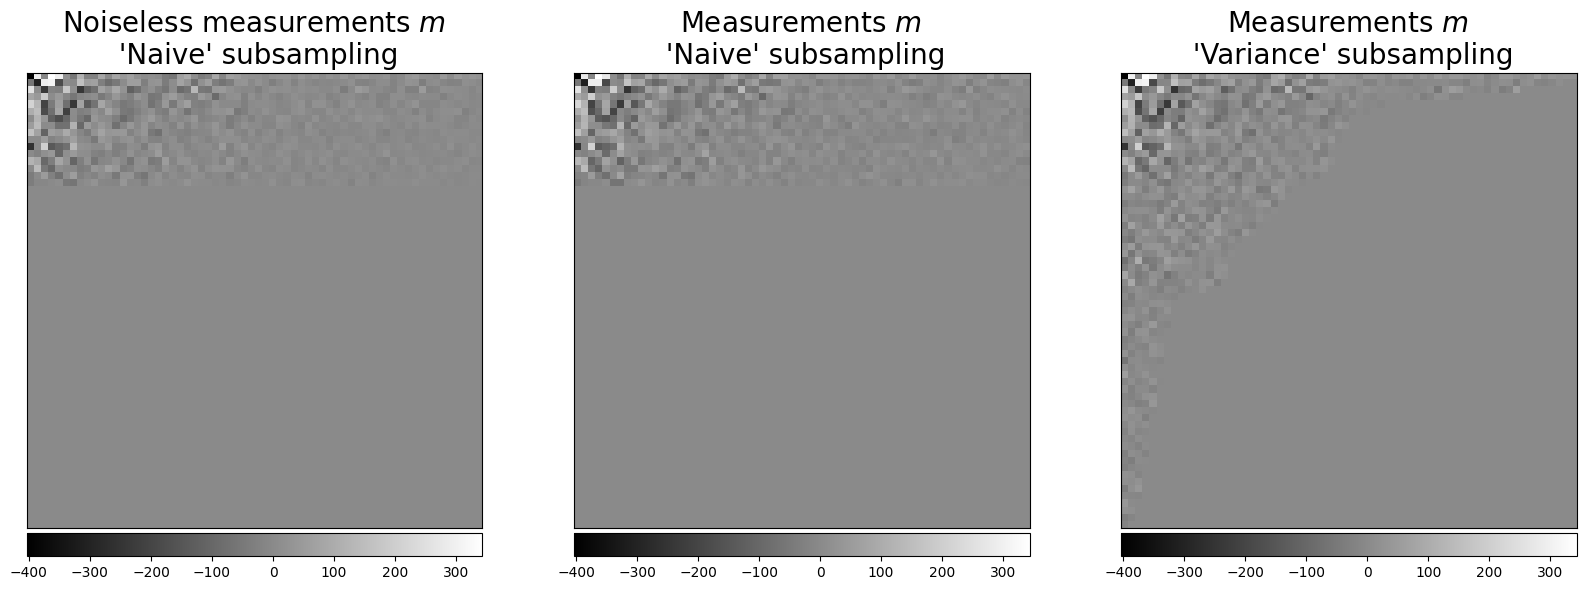

In [21]:
from spyrit.misc.sampling import meas2img2

# Plot the three measurement vectors
m_plot = m_nai_nonoise.numpy()
m_plot = meas2img2(m_plot.T, Ord_nai)
m_plot = np.moveaxis(m_plot, -1, 0)
m_plot_max = np.max(m_plot[0, :, :])
m_plot_min = np.min(m_plot[0, :, :])

m_plot2 = m_nai.numpy()
m_plot2 = meas2img2(m_plot2.T, Ord_nai)
m_plot2 = np.moveaxis(m_plot2, -1, 0)

m_plot3 = m_var.numpy()
m_plot3 = meas2img2(m_plot3.T, Ord_var)
m_plot3 = np.moveaxis(m_plot3, -1, 0)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
im1 = ax1.imshow(m_plot[0, :, :], cmap="gray")
ax1.set_title("Noiseless measurements $m$ \n 'Naive' subsampling", fontsize=20)
noaxis(ax1)
add_colorbar(im1, "bottom", size="20%")

im2 = ax2.imshow(m_plot2[0, :, :], cmap="gray", vmin=m_plot_min, vmax=m_plot_max)
ax2.set_title("Measurements $m$ \n 'Naive' subsampling", fontsize=20)
noaxis(ax2)
add_colorbar(im2, "bottom", size="20%")

im3 = ax3.imshow(m_plot3[0, :, :], cmap="gray", vmin=m_plot_min, vmax=m_plot_max)
ax3.set_title("Measurements $m$ \n 'Variance' subsampling", fontsize=20)
noaxis(ax3)
add_colorbar(im3, "bottom", size="20%")

#### PinvNet network



In [22]:
from spyrit.core.recon import PinvNet

# PinvNet(meas_op, prep_op, denoi=torch.nn.Identity())
pinvnet_nai_nonoise = PinvNet(nonoise_nai_op, prep_nonoise_op)
pinvnet_nai = PinvNet(noise_nai_op, prep_nai_op)
pinvnet_var = PinvNet(noise_var_op, prep_var_op)

# Reconstruction
z_nai_nonoise = pinvnet_nai_nonoise.reconstruct(y_nai_nonoise)
z_nai = pinvnet_nai.reconstruct(y_nai)
z_var = pinvnet_var.reconstruct(y_var)

We can now plot the three reconstructed images



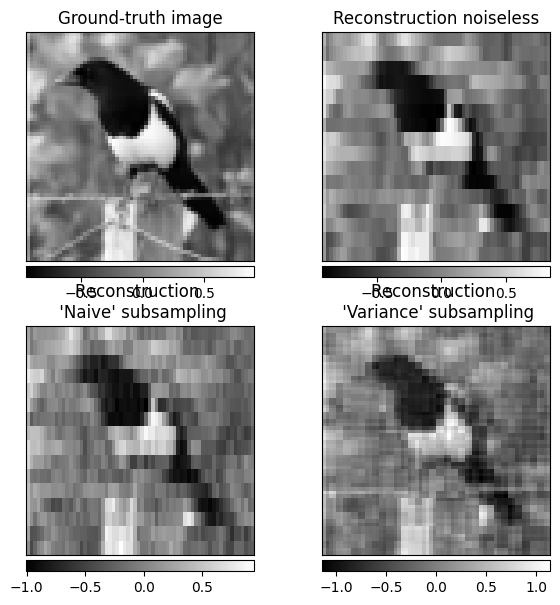

In [25]:
from spyrit.misc.disp import add_colorbar, noaxis

# Plot
x_plot = x.view(-1, h, h).numpy()
z_plot_nai_nonoise = z_nai_nonoise.view(-1, h, h).numpy()
z_plot_nai = z_nai.view(-1, h, h).numpy()
z_plot_var = z_var.view(-1, h, h).numpy()

f, axs = plt.subplots(2, 2, figsize=(7, 7))
im1 = axs[0, 0].imshow(x_plot[0, :, :], cmap="gray")
axs[0, 0].set_title("Ground-truth image")
noaxis(axs[0, 0])
add_colorbar(im1, "bottom")

im2 = axs[0, 1].imshow(z_plot_nai_nonoise[0, :, :], cmap="gray")
axs[0, 1].set_title("Reconstruction noiseless")
noaxis(axs[0, 1])
add_colorbar(im2, "bottom")

im3 = axs[1, 0].imshow(z_plot_nai[0, :, :], cmap="gray")
axs[1, 0].set_title("Reconstruction \n 'Naive' subsampling")
noaxis(axs[1, 0])
add_colorbar(im3, "bottom")

im4 = axs[1, 1].imshow(z_plot_var[0, :, :], cmap="gray")
axs[1, 1].set_title("Reconstruction \n 'Variance' subsampling")
noaxis(axs[1, 1])
add_colorbar(im4, "bottom")

plt.show()

In [24]:
import numpy as np

# Calculate signal power (total number of photons)
signal_power = np.sum(x_plot ** 2)  # Squared L2 norm of the original signal

# Calculate noise power for each reconstructed image
noise_power_nai_nonoise = np.sum((x_plot - z_plot_nai_nonoise) ** 2)  # Squared L2 norm of the difference
noise_power_nai = np.sum((x_plot - z_plot_nai) ** 2)  # Squared L2 norm of the difference
noise_power_var = np.sum((x_plot - z_plot_var) ** 2)  # Squared L2 norm of the difference

# Calculate SNR for each reconstructed image
SNR_nai_nonoise = 10 * np.log10(signal_power / noise_power_nai_nonoise)
SNR_nai = 10 * np.log10(signal_power / noise_power_nai)
SNR_var = 10 * np.log10(signal_power / noise_power_var)

print("SNR for  Nonoise Reconstruction:", SNR_nai_nonoise)
print("SNR for Naïve Reconstruction:", SNR_nai)
print("SNR for Variational Reconstruction:", SNR_var)


SNR for  Nonoise Reconstruction: 8.642502427101135
SNR for Naïve Reconstruction: 7.863938808441162
SNR for Variational Reconstruction: 10.31071424484253


Here  reconstructed images are pixelized when using the "naive subsampling",
      while they are smoother and more similar to the ground-truth image when using the
      "variance subsampling".